In this notebook, we use the Bollinger Bands method to perform Anomaly detection on Financial Data (from yfinance), get the news data that might have preceded the anomaly in the stocks and then use Sumy library and a local ollama model separately to summarize the news information into getting a reason on why the stock anomaly took place.

Here we get our necessary imports.

In [2]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import spacy
import re

For getting the news data, Enter your news api key and ID below

In [ ]:
# API Credentials
NEWSAPI_APP_KEY = ""
NEWSAPI_APP_ID = ""

Here are the parameters we use in the code, Feel free to modify as needed

  **start_date** = Enter the date of the start of financial data (YYYY-MM-DD)

   **end_date** = Enter the date of the end of the financial data, currently set to get the current date

   **STOCK_TICKER** = Enter the stock ticker code for which to get the data for

   **STOCK_NAME** = Enter the name of the company concerned with the stock ticker
 
   **ollama_model** = Specify the ollama model to use for news summarization (*Must be installed on your local machine with Ollama running*)

In [7]:
start_date = "2023-08-03"
end_date = datetime.now().strftime('%Y-%m-%d')
STOCK_NAME = "JPMorgan"
STOCK_TICKER = "JPM"
ollama_model = "llama3.2:3b"


Now we download the financial data from yfinance

In [8]:
fin_data = yf.download(STOCK_TICKER, start=start_date, end=end_date, interval="1d")

finance_csv_file = "financial_anomaly_data.csv"
fin_data.to_csv(finance_csv_file)
print(f"financial data saved to {finance_csv_file}")

[*********************100%***********************]  1 of 1 completed

financial data saved to financial_anomaly_data.csv


Code to normalize the financial data

In [ ]:
# Load raw CSV without setting headers
df_raw = pd.read_csv("financial_anomaly_data.csv", header=None)

# Extract column names from row 0
column_names = df_raw.iloc[0].tolist()
column_names[0] = "Date"

# Extract the actual financial data from row 3 onwards
df_financial = df_raw.iloc[3:].copy()

# Assign proper column names
df_financial.columns = column_names

# Convert "Date" column to datetime
df_financial["Date"] = pd.to_datetime(df_financial["Date"], errors="coerce")

# Ensure numerical columns are properly converted
num_cols = df_financial.columns[1:]  # Exclude "Date"
df_financial[num_cols] = df_financial[num_cols].apply(pd.to_numeric, errors="coerce")

# Sort by date
df_financial = df_financial.sort_values("Date").reset_index(drop=True)

# Save the cleaned financial data
df_financial.to_csv("processed_financial_data.csv", index=False)

print("Financial data")
print(df_financial.head())

Financial data
        Date       Close        High         Low        Open   Volume
0 2023-08-03  150.806152  151.355934  148.877068  149.504015  6084000
1 2023-08-04  150.487869  152.204753  150.179209  150.854385  6206600
2 2023-08-07  151.201630  152.108302  151.047314  151.047314  7251800
3 2023-08-08  150.352829  150.449274  147.179477  148.848146  8623400
4 2023-08-09  148.336914  150.005582  148.028268  149.812677  6277800


Here we use Bollinger Bands Method (You can read more about it [Here](https://en.wikipedia.org/wiki/Bollinger_Bands)) to detect anomalies in the financial data.

The blue lines denote a stock surge while the red lines denote a stock crash

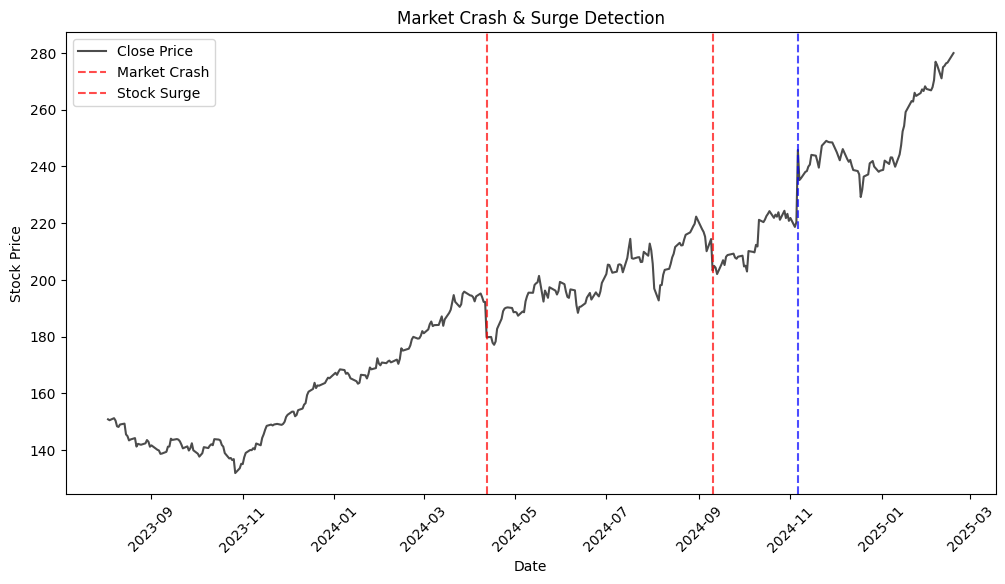

In [ ]:
# Load processed financial data
df = pd.read_csv("processed_financial_data.csv")

# Convert "Date" to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Compute Daily Returns
df["Returns"] = df["Close"].pct_change() * 100  # Convert to percentage

# Compute Rolling Volume Mean & Standard Deviation
window = 20
df["RollingVolume"] = df["Volume"].rolling(window=window).mean()
df["RollingStdVolume"] = df["Volume"].rolling(window=window).std()

# Compute Volatility (Rolling Standard Deviation of Returns)
df["Volatility"] = df["Returns"].rolling(window=window).std()

# Detect Anomalies
df["Anomaly"] = 0  # Default: No anomaly

# Detect Market Crashes (Large Drops)
df.loc[(df["Returns"] < -5), "Anomaly"] = -1  # Crash detected

# Detect Rapid Price Surges (Stock Skyrocketing)
df.loc[(df["Returns"] > 5), "Anomaly"] = 1  # Surge detected

# Detect High Volume Spikes
df["HighVolume"] = df["Volume"] > (df["RollingVolume"] + df["RollingStdVolume"] * 2)

# Filter only significant anomalies (confirmed by high volume)
df.loc[(df["Anomaly"] != 0) & (df["HighVolume"] == True), "Confirmed_Anomaly"] = df["Anomaly"]

# Save detected anomalies
df.to_csv("market_crashes_and_surges.csv", index=False)

# Plot Market Crashes & Surges
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Close Price", color="black", alpha=0.7)

# Add vertical lines for Market Crashes
for crash_date in df[df["Anomaly"] == -1]["Date"]:
    plt.axvline(x=crash_date, color="red", linestyle="--", alpha=0.7)

# Add vertical lines for Stock Surges
for surge_date in df[df["Anomaly"] == 1]["Date"]:
    plt.axvline(x=surge_date, color="blue", linestyle="--", alpha=0.7)

plt.legend(["Close Price", "Market Crash", "Stock Surge"])
plt.title("Market Crash & Surge Detection")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.show()



Now we use the news signals api to get news +- 2 days from each of the anomalies. 

Feel free to change the **start_date** and **end_date** arguments to change the time period from which the news is retrieved.

In [ ]:
HEADERS = {
    'X-AYLIEN-NewsAPI-Application-ID': NEWSAPI_APP_ID,
    'X-AYLIEN-NewsAPI-Application-Key': NEWSAPI_APP_KEY
}

# Load detected anomalies
df_anomalies = pd.read_csv("market_crashes_and_surges.csv")

# Convert "Date" to datetime
df_anomalies["Date"] = pd.to_datetime(df_anomalies["Date"])

# Store news results
news_results = []

for _, row in df_anomalies.iterrows():
    anomaly_date = row["Date"]
    anomaly_type = row["Anomaly"]

    # Define search window (±2 days)
    start_date = (anomaly_date - timedelta(days=2)).strftime('%Y-%m-%dT00:00:00.000Z')
    end_date = (anomaly_date + timedelta(days=2)).strftime('%Y-%m-%dT23:59:59.999Z')

    # Determine situation type
    situation = "Stock Surge" if anomaly_type == 1 else "Market Crash" if anomaly_type == -1 else None
    if situation is None:
        continue  # Skip if no anomaly detected

    # **Build Query for Aylien API**
    entities_query = '{{surface_forms:("' + STOCK_NAME + '" OR "' + STOCK_TICKER + '") AND overall_prominence:>=0.65}}'

    # API request parameters
    params = {
        "published_at.start": start_date,
        "published_at.end": end_date,
        "language": "en",
        "entities": entities_query,
        "source.rankings.alexa.rank.min": "1",
        "source.rankings.alexa.rank.max": 10,
        "per_page": 5,  # Get top 5 relevant articles
    }

    # Call Aylien News API
    response = requests.get("https://api.aylien.com/v6/news/stories", params=params, headers=HEADERS)
    
    if response.status_code == 200:
        result = response.json()
        articles = result.get("stories", [])

        # Print situation heading
        print("\n" + "="*40)
        print(f"News Articles for {situation} on {anomaly_date.strftime('%Y-%m-%d')}")
        print("="*40)

        # Add separator for CSV readability
        news_results.append({"Anomaly Date": "", "Stock": "", "Type": "", "Title": "", "Body": "", "Published Date": "", "Source": "", "URL": ""})
        news_results.append({"Anomaly Date": f"==== {situation}: {anomaly_date.strftime('%Y-%m-%d')} ====", "Stock": "", "Type": "", "Title": "", "Body": "", "Published Date": "", "Source": "", "URL": ""})
        
        for article in articles:
            news_entry = {
                "Anomaly Date": anomaly_date.strftime('%Y-%m-%d'),
                "Stock": STOCK_NAME,
                "Type": situation,
                "Title": article["title"],
                "Body": article.get("body", "No article body available"),  # Store article body
                "Published Date": article["published_at"][:10],
                "Source": article["source"]["name"],
                "URL": article["links"]["permalink"]
            }
            news_results.append(news_entry)

            # Print each news entry
            print(f"- {article['title']} ({article['published_at'][:10]})")
            print(f"  Source: {article['source']['name']}")
            print(f"  URL: {article['links']['permalink']}\n")
            print(f"  Body: {article.get('body', 'No article body available')[:200]}...\n")  # Print first 200 chars

    else:
        print(f"Error fetching news for {anomaly_date}: {response.status_code} - {response.text}")

# Convert news results to DataFrame
df_news = pd.DataFrame(news_results)

# Save news articles related to anomalies
df_news.to_csv("anomaly_news_results.csv", index=False)

print("\nNews results saved to anomaly_news_results.csv")


News Articles for Market Crash on 2024-04-12
- The Q1 Earnings Season Kicks off Positively (2024-04-13)
  Source: Yahoo UK
  URL: https://uk.finance.yahoo.com/news/q1-earnings-season-kicks-off-202800895.html

  Body: In this article:  ^GSPC  The market isn't particularly impressed with what it saw in the quarterly releases from JPMorgan JPM, Citigroup C, and even Wells Fargo WFC.
Part of the issue appears to be un...

- JPMorgan earnings call struck 'cautious' tone on high rates - Yahoo Finance (2024-04-13)
  Source: Google News
  URL: https://news.google.com/rss/articles/CBMiVWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vdmlkZW8vanBtb3JnYW4tZWFybmluZ3MtY2FsbC1zdHJ1Y2stY2F1dGlvdXMtMTU1MTU0NDY1Lmh0bWzSAQA?oc=5

  Body: <ol><li><a href="https://news.google.com/rss/articles/CBMiVWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vdmlkZW8vanBtb3JnYW4tZWFybmluZ3MtY2FsbC1zdHJ1Y2stY2F1dGlvdXMtMTU1MTU0NDY1Lmh0bWzSAQA?oc=5" target="_blank">...

- Jamie Dimon warns that markets are 'too happy' and failing to price in a po

To install sumy library required for non-LLM based summarization. Only need to run this once.

In [ ]:
!pip install sumy

Now we use the sumy and spacy libraries to perform non-LLM based news summarization.

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.text_rank import TextRankSummarizer

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

class SpacyTokenizer:
    def __init__(self, language="english"):
        self.language = language

    def to_sentences(self, text):
        """Split text into sentences using SpaCy"""
        doc = nlp(text)
        return [sent.text for sent in doc.sents]

    def to_words(self, text):
        """Tokenize text into words using SpaCy"""
        doc = nlp(text)
        return [token.text for token in doc if not token.is_space]

# Summarization function
def summarize_article(text, num_sentences=2):
    """ Extractive summarization using TextRank with SpaCy tokenizer """
    if pd.isna(text) or text.strip() == "":
        return "No content available for summarization."

    parser = PlaintextParser.from_string(text, SpacyTokenizer()) 
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join([str(sentence) for sentence in summary])

# Load news data
df_news = pd.read_csv("anomaly_news_results.csv", dtype=str)

# Process CSV row by row to identify event headers and summarize articles
current_event = None

for _, row in df_news.iterrows():
    # Check if the row is a section header
    if re.match(r"==== (Market Crash|Stock Surge): \d{4}-\d{2}-\d{2} ====", str(row.iloc[0])):
        current_event = row.iloc[0]  # Store the event header
        print("\n" + "="*60)
        print(f"{current_event}")  # Print event heading
        print("="*60)
        continue  # Move to next row

    # If it's a normal news row, summarize it
    if current_event:
        title = row["Title"]
        body = row.get("Body", title) 
        url = row["URL"]
        summary = summarize_article(body)  

        print(f"\n **{title}**")
        print(f"Summary: {summary}")
        print(f"Source: {url}")
        print("-" * 40)




==== Market Crash: 2024-04-12 ====

 **The Q1 Earnings Season Kicks off Positively**
Summary: The Earnings Big Picture Looking at Q1 as a whole, total S&P 500 earnings are expected to be up +2.9% from the same period last year on +3.8% higher revenues, which would follow the +6.8% earnings growth on +4.0% revenue gains in the preceding period. For 2024 Q1, net margins are expected to be below the year-earlier level for 9 of the 16 Zacks sectors, with the biggest declines in the Energy, Basic Materials, Autos, and Medical sectors.
Source: https://uk.finance.yahoo.com/news/q1-earnings-season-kicks-off-202800895.html
----------------------------------------

 **JPMorgan earnings call struck 'cautious' tone on high rates - Yahoo Finance**
Summary: <ol><li><a href="https://news.google.com/rss/articles/CBMiVWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vdmlkZW8vanBtb3JnYW4tZWFybmluZ3MtY2FsbC1zdHJ1Y2stY2F1dGlvdXMtMTU1MTU0NDY1Lmh0bWzSAQA?oc=5" target="_blank">JPMorgan earnings call struck 'cautious' tone

Here we use ollama to perform news-summarization using a LLM 

In [ ]:
import pandas as pd
import re
import requests

# Load news data from CSV
df_news = pd.read_csv("anomaly_news_results.csv", dtype=str)

# Function to summarize all articles for a single Market Crash/Surge event
def summarize_event_ollama(event_text, event_type, event_date):
    """Summarize all news articles related to a Market Crash or Stock Surge event via Ollama API."""
    if not event_text.strip():
        return "No relevant news articles available for summarization."

    prompt = (
        f"TELL ME THE REASON FOR {event_type} OF {STOCK_NAME} ON {event_date} IN MAXIMUM 10 LINES IN  1 PARAGRAPH ACCORDING TO THE GIVEN NEWS AROUND THAT DATE HERE:\n\n"
        f"{event_text}"
    )

    # Send request to Ollama's API
    response = requests.post(
        "http://localhost:11434/api/generate",  # Ollama's local API endpoint
        json={"model": ollama_model, "prompt": prompt, "stream": False}
    )

    if response.status_code == 200:
        return response.json()["response"].strip()
    else:
        return f"Error: Ollama API responded with {response.status_code}"

# Process CSV row by row to summarize grouped articles per event
summarized_results = []
current_event = None
event_articles = []  # Stores all articles for a single event

for _, row in df_news.iterrows():
    # Check if the row is a section header (identifying a new event)
    if re.match(r"==== (Market Crash|Stock Surge): \d{4}-\d{2}-\d{2} ====", str(row.iloc[0])):
        # If there's a previous event, summarize all collected articles
        if current_event and event_articles:
            combined_text = "\n\n".join(str(article) for article in event_articles if isinstance(article, str))
            summary = summarize_event_ollama(combined_text, event_type, event_date)

            summarized_results.append({
                "Anomaly Date": event_date,
                "Stock": STOCK_NAME,
                "Type": event_type,
                "Summary": summary
            })

            print(f"\n**Summary for {event_type} on {event_date}**")
            print(f"{summary}")
            print("=" * 60)

        # Start a new event
        current_event = row.iloc[0]
        event_articles = []  # Reset articles for new event
        event_type, event_date = re.search(r"==== (Market Crash|Stock Surge): (\d{4}-\d{2}-\d{2}) ====", current_event).groups()
        continue  # Move to the next row

    # If it's a normal news row, collect the news body
    if current_event:
        body = row.get("Body", row["Title"])  # Use 'Body' if available, otherwise use the Title
        event_articles.append(body)

# Process the last event in the file
if current_event and event_articles:
    combined_text = "\n\n".join(event_articles)
    summary = summarize_event_ollama(combined_text, event_type, event_date)

    summarized_results.append({
        "Anomaly Date": event_date,
        "Stock": STOCK_NAME,
        "Type": event_type,
        "Summary": summary
    })

    print(f"\n**Summary for {event_type} on {event_date}**")
    print(f"{summary}")
    print("=" * 60)

# Convert summarized results to DataFrame
df_summarized = pd.DataFrame(summarized_results)

# Save summarized news articles to a CSV file
df_summarized.to_csv("summarized_anomaly_news_results.csv", index=False)

print("\nSummarized news results saved to summarized_anomaly_news_results.csv")




**Summary for Market Crash on 2024-04-12**
The article discusses the recent earnings report from JPMorgan Chase, one of the largest banks in the US. Here are some key points:

* Net interest income, a key driver of bank profits, declined by 5% year-over-year.
* Jamie Dimon, JPMorgan's CEO, warned that the banking sector is facing "persistent inflationary pressures" and that higher interest rates may continue to erode profit margins.
* The bank reported a 6% increase in profits for the first quarter, but Dimon said that this growth was not sustainable due to rising costs and declining revenue from net interest income.
* JPMorgan's shares fell after the earnings report, indicating investor concerns about the bank's ability to maintain profitability in a rising-rate environment.
* The article suggests that higher interest rates have been a significant profit driver for banks in recent years, but now these rates are rising and eroding those profits.

Overall, the article suggests that JPM